# Linear Regression VS Bayesian Regression

## Key Differences
- Bayesian models provide uncertainty estimates, which are important in determining how our model performs (how robust our model is) under certain parameter values.
- Under a Bayesian framework, we can encode knowledge about parameters to supplement the model. For example, consider this toy problem: we are trying to find the error in a piece of apparatus that measures the acceleration of objects. We gather data by measuring dropping objects from a height and measuring their acceleration - which should be close to gravity. This "knowledge" about what the acceleration should be can be encoded into a Bayesian model, but cannot be used in a frequentist model.

In [1]:
#hide
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

df = df[np.isfinite(df.rgdppc_2000)] # remove NaNs
df["rgdppc_2000"] = np.log(df["rgdppc_2000"]) # log real GPD per capita

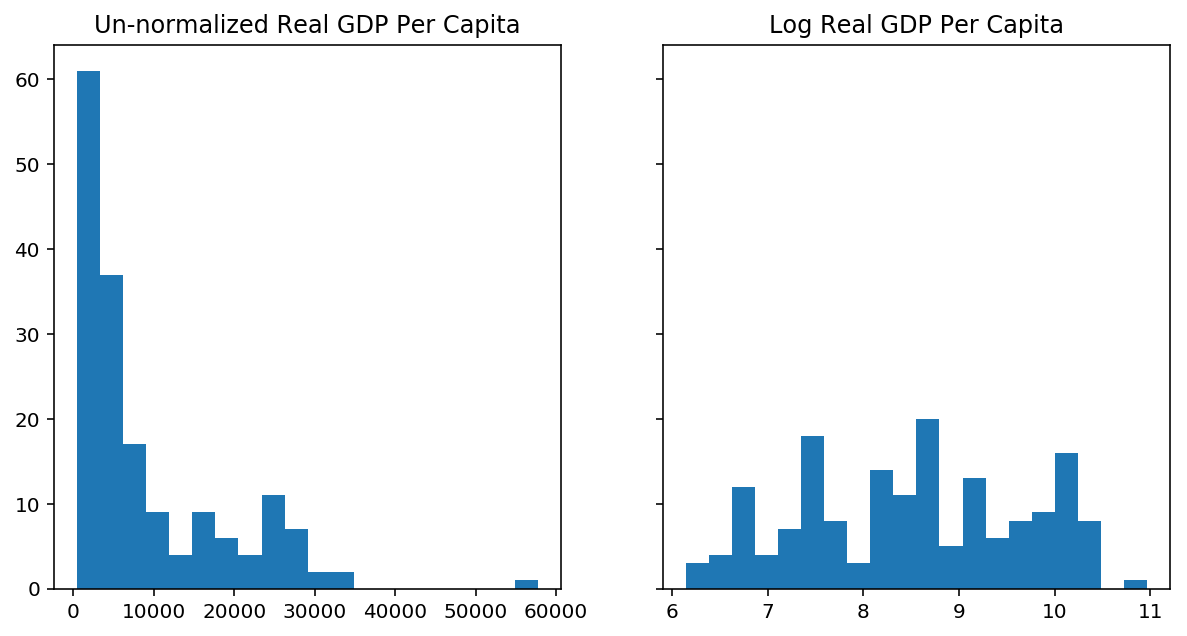

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
ax[0].hist(data[np.isfinite(data.rgdppc_2000)].rgdppc_2000, bins = 20)
ax[0].set(title="Un-normalized Real GDP Per Capita")
ax[1].hist(df.rgdppc_2000, bins = 20)
ax[1].set(title="Log Real GDP Per Capita");

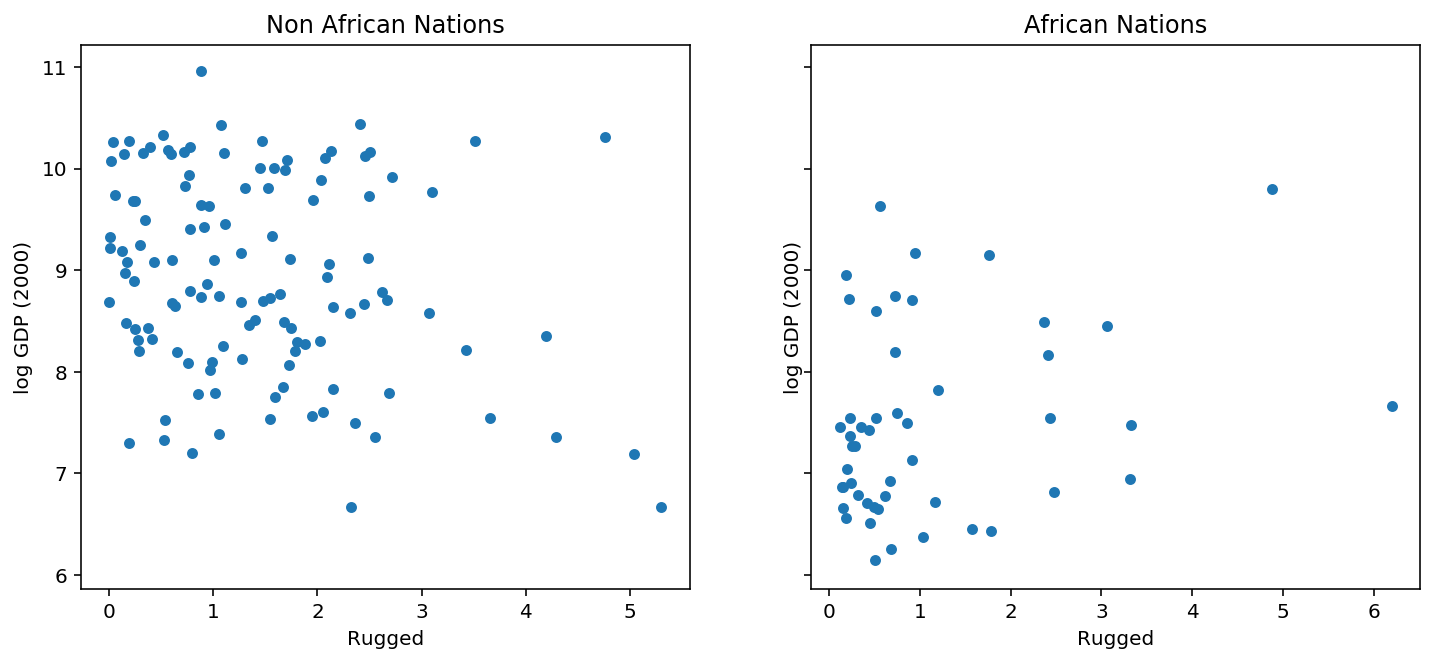

In [4]:
# add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
ax[0].scatter(non_african_nations["rugged"],
              non_african_nations["rgdppc_2000"], 
              s = 20)
ax[0].set(xlabel="Rugged",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].scatter(african_nations["rugged"],
              african_nations["rgdppc_2000"],
              s = 20)
ax[1].set(xlabel="Rugged",
          ylabel="log GDP (2000)",
          title="African Nations");

### Simple Linear Regression

In [5]:
features = ["rugged", "cont_africa_x_rugged", "cont_africa"]
x = df[features]
y = df["rgdppc_2000"]

reg = LinearRegression()
_ = reg.fit(x, y)

coef = dict([i for i in zip(list(x.columns), reg.coef_)]); coef
print("Intercept: %f" % reg.intercept_)
print("Coefficient of Determination: %f" % reg.score(x, y))

{'rugged': -0.20285708606709807,
 'cont_africa_x_rugged': 0.393393801193117,
 'cont_africa': -1.9480479960116401}

Intercept: 9.223226
Coefficient of Determination: 0.356925


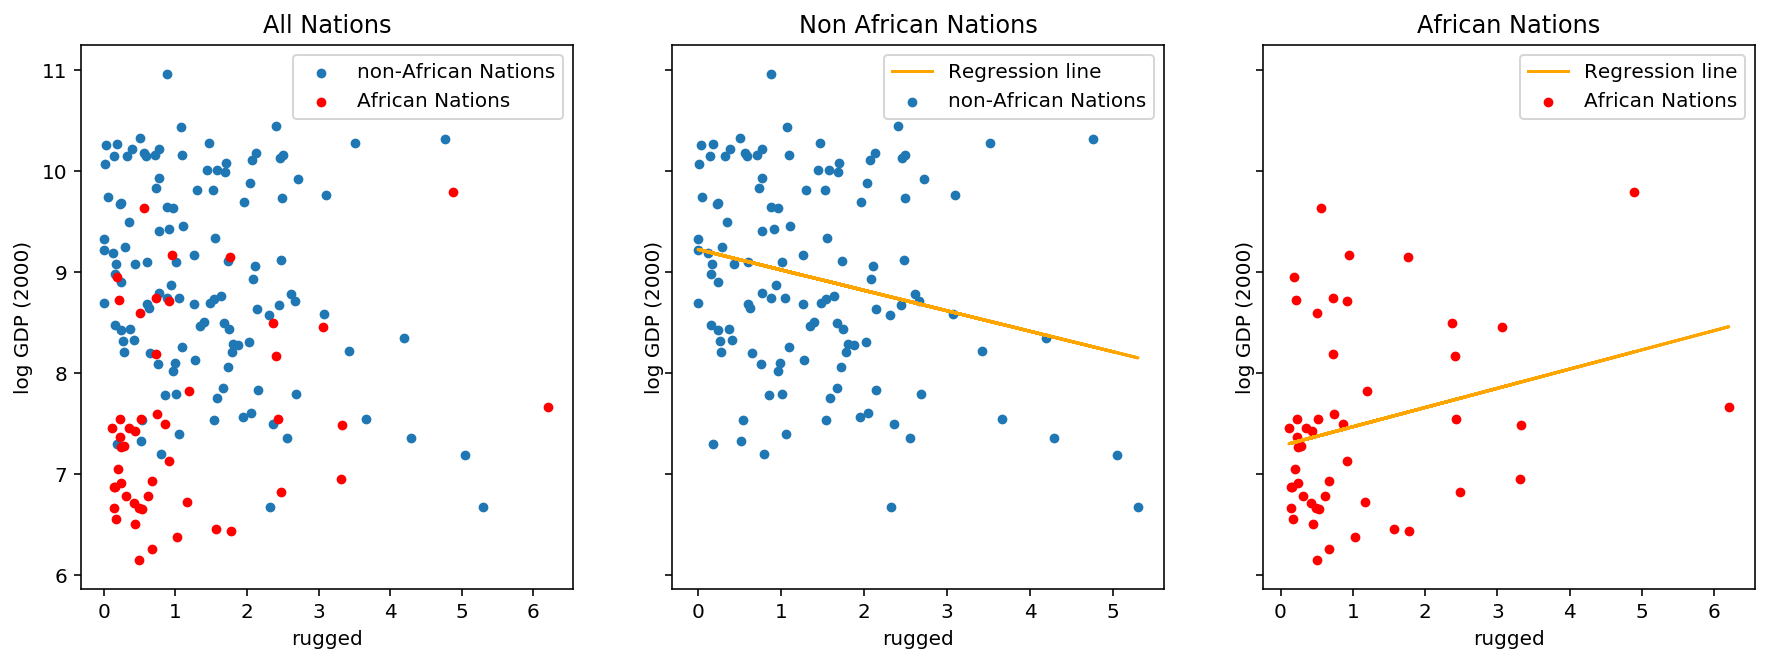

In [6]:
# predict GPD from continent and terrain
african_gdp = reg.predict(african_nations[features])
non_african_gdp = reg.predict(non_african_nations[features])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
ax[0].scatter(non_african_nations["rugged"],
              non_african_nations["rgdppc_2000"],
              label="non-African Nations",
              s = 15)
ax[0].scatter(african_nations["rugged"],
              african_nations["rgdppc_2000"],
              color = "red",
              label="African Nations",
              s = 15)
ax[0].set(xlabel="rugged",
          ylabel="log GDP (2000)",
          title="All Nations");
ax[0].legend()

ax[1].plot(non_african_nations["rugged"],
           non_african_gdp,
           color = "orange",
           label = "Regression line")
ax[1].scatter(non_african_nations["rugged"],
              non_african_nations["rgdppc_2000"],
              label="non-African Nations",
              s = 15)
ax[1].set(xlabel="rugged",
          ylabel="log GDP (2000)",
          title="Non African Nations")

ax[2].plot(african_nations["rugged"],
           african_gdp,
           color = "orange",
           label = "Regression line")
ax[2].scatter(african_nations["rugged"],
              african_nations["rgdppc_2000"],
              color = "red",
              label="African Nations",
              s = 15)
ax[2].set(xlabel="rugged",
          ylabel="log GDP (2000)",
          title="African Nations")
ax[1].legend()
ax[2].legend();

In [7]:
# backout the slopes of lines for nations in and out of Africa
print("Slope for African nations: ", coef["rugged"] + coef["cont_africa_x_rugged"])
print("Slope for non-African nations: ", coef["rugged"])

Slope for African nations:  0.19053671512601894
Slope for non-African nations:  -0.20285708606709807


## Bayesian Regression with Pyro

In [8]:
#hide
from functools import partial
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule

from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

In [9]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # PyroSample used to declare priors:
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        # sample from the posterior
        obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [10]:
tensor_data = torch.tensor(df.values, dtype=torch.float)
x_data = tensor_data[:, [0, 1, 3]]
y_data = tensor_data[:, 2] # 

The `guide` code below is Pyro's way of allowing us to specify a distribution to model the posterior after, we'll bypass specifying this outselves and use the `AutoDiagonalNormal` function, which does this automatically for us.

We'll use stochastic variational inference to approximate the posterior.

In [11]:
model = BayesianRegression(3, 1)
auto_guide = AutoDiagonalNormal(model)

svi = SVI(model = model, # bayesian regression class  
          guide = auto_guide, # using auto guide
          optim = pyro.optim.Adam({"lr": 0.05}),
          loss=Trace_ELBO())

In [12]:
num_iterations = 2500

# param_store is where pyro stores param estimates
pyro.clear_param_store()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 250 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 2.4419
[iteration 0251] loss: 1.0558
[iteration 0501] loss: 1.0728
[iteration 0751] loss: 1.0556
[iteration 1001] loss: 1.0506
[iteration 1251] loss: 1.0858
[iteration 1501] loss: 1.0672
[iteration 1751] loss: 1.0590
[iteration 2001] loss: 1.0810
[iteration 2251] loss: 1.0651


In [13]:
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal()

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2482, -1.8963, -0.1812,  0.3613,  9.1599])
AutoDiagonalNormal.scale tensor([0.0574, 0.1380, 0.0632, 0.0763, 0.0676])


In [14]:
num_samples = 1000
predictive = Predictive(model = model, 
                        guide = auto_guide, 
                        num_samples = num_samples,
                        return_sites=("linear.weight", "linear.bias", "obs", "_RETURN"))
pred = predictive(x_data)
weight = pred["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
bias = pred["linear.bias"]

In [15]:
# columns of x_data: cont_africa, rugged, cont_africa_x_rugged 
print("Mean for posterior distributions: ", torch.mean(weight, 0))
print("97.5 percentile: ", weight.kthvalue(int(num_samples * 0.975), dim = 0)[0]) # find the 97.5 percentile value
print("2.5 percentile: ", weight.kthvalue(int(num_samples * 0.025), dim = 0)[0]) # find the 2.5 percentile value

Mean for posterior distributions:  tensor([-1.8953, -0.1789,  0.3634])
97.5 percentile:  tensor([-1.6276, -0.0601,  0.5170])
2.5 percentile:  tensor([-2.1632, -0.2923,  0.2238])


In [16]:
columns = ["cont_africa", "rugged", "cont_africa_x_rugged"]
bayes_coef = dict(zip(columns, torch.mean(weight, 0).numpy()))

print("Slope for African nations: ", bayes_coef["rugged"] + bayes_coef["cont_africa_x_rugged"])
print("Slope for non-African nations: ", bayes_coef["rugged"])

Slope for African nations:  0.1845063
Slope for non-African nations:  -0.17887932


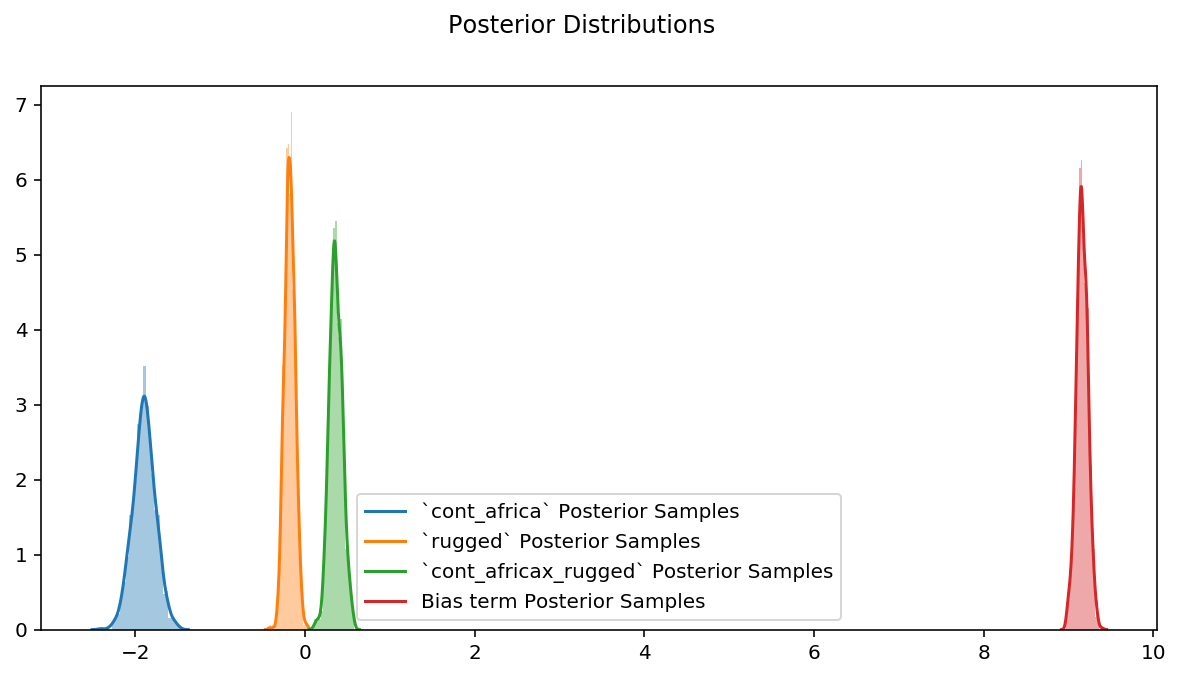

In [17]:
fig = plt.figure(figsize = (10, 5))
sns.distplot(weight[:, 0], kde_kws = {"label": "`cont_africa` Posterior Samples"})
sns.distplot(weight[:, 1], kde_kws = {"label": "`rugged` Posterior Samples"})
sns.distplot(weight[:, 2], kde_kws = {"label": "`cont_africax_rugged` Posterior Samples"})
sns.distplot(bias[:, 0], kde_kws = {"label": "Bias term Posterior Samples"})

fig.suptitle("Posterior Distributions");

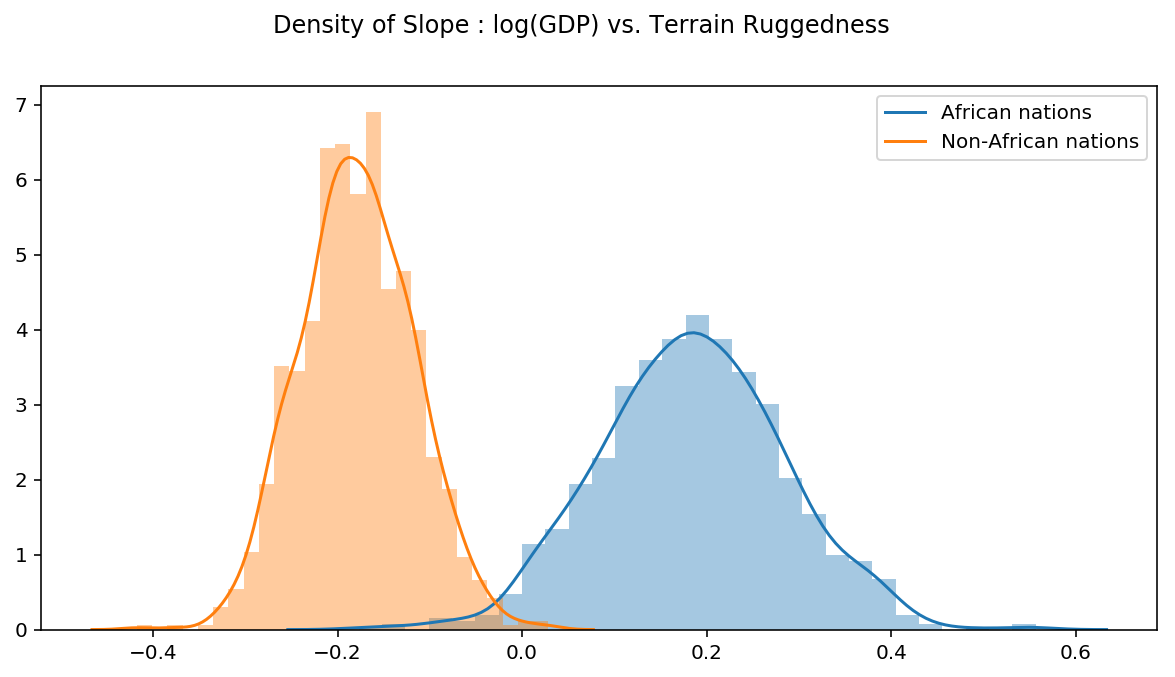

In [18]:
in_africa = weight[:, 1] + weight[:, 2] # rugged + cont_africa_x_rugged
outside_africa = weight[:, 1] # rugged

fig = plt.figure(figsize=(10, 5))
sns.distplot(in_africa, 
             kde_kws = {"label": "African nations"},)
sns.distplot(outside_africa,
             kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

In [19]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.025), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.975), dim=0)[0],
        }
    return site_stats

samples = predictive(x_data)
pred_summary = summary(samples)

In [20]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})
predictions.head()

,cont_africa,rugged,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_gdp
0,1.0,0.858,7.426625,7.109407,7.791074,7.463451,5.543858,9.445796,7.492610
1,0.0,3.427,8.534957,8.064401,8.950467,8.523244,6.522863,10.414194,8.216929
2,0.0,0.769,9.019382,8.854181,9.178275,8.991613,6.938167,10.868880,9.933263
3,0.0,0.775,9.018296,8.852330,9.178236,9.015988,7.157776,10.826462,9.407031
4,0.0,2.688,8.669643,8.289905,9.005231,8.659996,6.624380,10.615388,7.792343


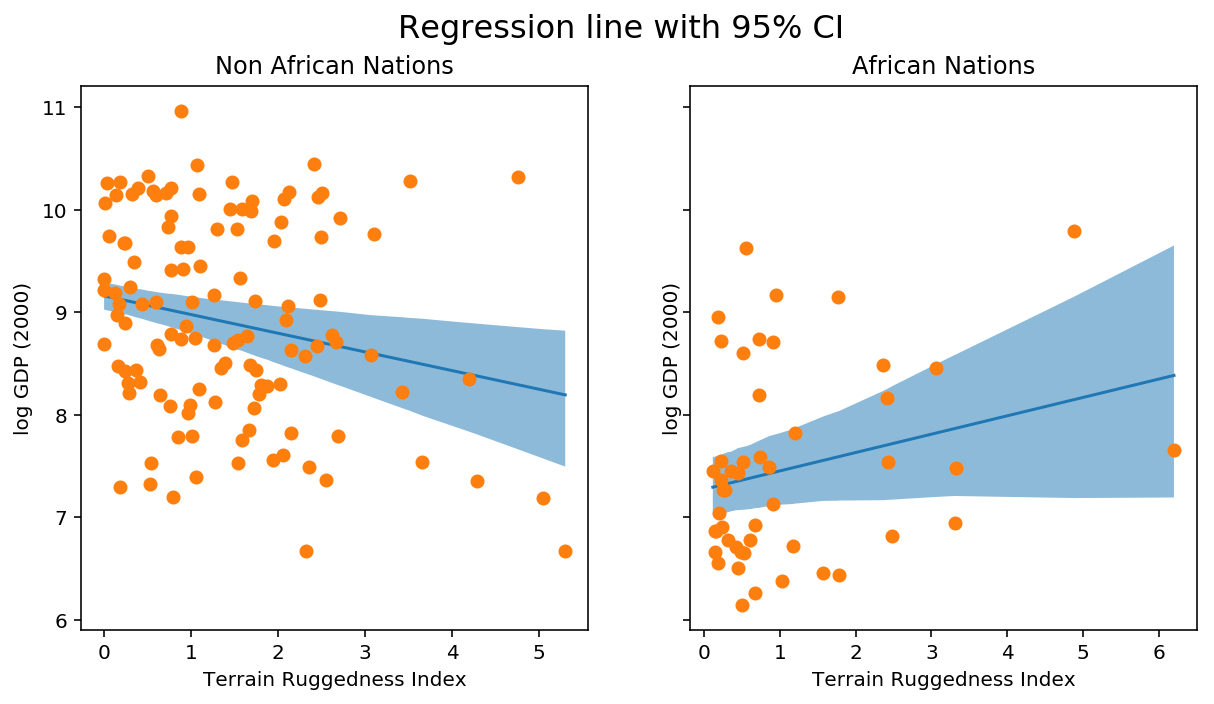

In [21]:
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Regression line with 95% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We can look at the distribution of slope of log GDP given terrain ruggedness for nations within and outside Africa.

## Resources
- http://www.gaussianprocess.org/gpml/chapters/RW.pdf
- http://www.greenteapress.com/thinkbayes/thinkbayes.pdf
- https://pyro.ai/examples/bayesian_regression.html#Linear-Regression